In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os, requests, pandas as pd
!pip -q install pandas requests
from urllib.parse import urlencode
!pip install mysql-connector-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 34.5 MB/s eta 0:00:00


### Loading Data Directly From ThingSpeak

In [2]:
# 1. Load Data
from datetime import timedelta

CHANNEL_ID = "3015898"
READ_API_KEY = "2RZJGMVY0SJCX997"

url = f"https://api.thingspeak.com/channels/{CHANNEL_ID}/feeds.csv?api_key={READ_API_KEY}&results=10000"

# Load directly into Pandas
df = pd.read_csv(url)

# Parse as UTC first
df["created_at"] = pd.to_datetime(df["created_at"], utc=True, errors="coerce")

# Add +8h to convert to Singapore local time
df["created_at"] = df["created_at"] + timedelta(hours=8)

# Drop timezone info so MySQL DATETIME can store it
df["created_at"] = df["created_at"].dt.tz_localize(None)


print(df.tail())

              created_at  entry_id    field1    field2  field3
3133 2025-08-21 16:37:02      3134  26.17227  62.80308      22
3134 2025-08-21 16:49:04      3135  26.32715  62.33615      22
3135 2025-08-21 17:01:07      3136  26.28710  62.60624      22
3136 2025-08-21 17:13:10      3137  26.24437  62.58793      22
3137 2025-08-21 17:25:13      3138  26.13222  62.78477      22


### Data Preprocessing

#### Handle missing values

In [3]:
# 3. Handle missing values
# Drop rows where ALL sensor fields are missing
df = df.dropna(subset=["field1", "field2", "field3"], how="all")
# Forward fill to keep time series continuity
df[["field1", "field2", "field3"]] = df[["field1", "field2", "field3"]].fillna(method="ffill")

/tmp/ipython-input-2196332269.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[["field1", "field2", "field3"]] = df[["field1", "field2", "field3"]].fillna(method="ffill")


#### Format Timestamp

In [4]:
# 4. Format timestamp
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
df = df.dropna(subset=["created_at"])  # drop invalid timestamps
df = df.sort_values("created_at")      # sort by time

#### Rename the columns

In [5]:
# 5. Rename the columns
df = df.rename(columns={
    "field1": "temperature",
    "field2": "humidity",
    "field3": "air_quality"
})


#### Sanity Check
Removed unreasonable values

In [6]:
# 6. Sanity checks (clipping ranges)
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce").clip(-10, 80)
df["humidity"]    = pd.to_numeric(df["humidity"], errors="coerce").clip(0, 100)
df["air_quality"] = pd.to_numeric(df["air_quality"], errors="coerce").clip(lower=0)

#### Save the cleaned dataset

In [7]:
# 7. Save cleaned dataset
df.to_csv("feeds_clean_named.csv", index=False)

#### Scaling

In [8]:
# 8. Scaling (Min-Max to 0–1)
scaler_minmax = MinMaxScaler()
df_scaled = df.copy()
df_scaled[["temperature", "humidity", "air_quality"]] = scaler_minmax.fit_transform(
    df_scaled[["temperature", "humidity", "air_quality"]]
)
df_scaled.to_csv("feeds_scaled.csv", index=False)

#### Normalization

In [9]:
# 9. Normalization (Z-score: mean=0, std=1)
scaler_standard = StandardScaler()
df_norm = df.copy()
df_norm[["temperature", "humidity", "air_quality"]] = scaler_standard.fit_transform(
    df_norm[["temperature", "humidity", "air_quality"]]
)
df_norm.to_csv("feeds_normalized.csv", index=False)

### Connection to MySQL

#### Store the preprocessed data to MySQL

In [12]:
import mysql.connector as mysql

NGROK_HOST = "0.tcp.ap.ngrok.io"
NGROK_PORT = 17356
DB_USER    = "user"
DB_PASS    = "az3!May131019"
DB_NAME    = "factory_env"

def upsert_mysql(df):
    if df.empty:
        print("No rows to insert.")
        return
    conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                         user=DB_USER, password=DB_PASS, database=DB_NAME)
    cur = conn.cursor()
    rows = list(df[["entry_id","created_at","temperature","humidity","air_quality"]]
                .itertuples(index=False, name=None))
    cur.executemany("""
      INSERT INTO sensor_feeds(entry_id, created_at, temperature, humidity, air_quality)
      VALUES (%s,%s,%s,%s,%s)
      ON DUPLICATE KEY UPDATE
        created_at=VALUES(created_at),
        temperature=VALUES(temperature),
        humidity=VALUES(humidity),
        air_quality=VALUES(air_quality);
    """, rows)
    conn.commit(); cur.close(); conn.close()
    print(f"Upserted {len(rows)} rows.")


In [13]:
upsert_mysql(df)

Upserted 3138 rows.


In [14]:
conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                     user=DB_USER, password=DB_PASS, database=DB_NAME)
daily = pd.read_sql("SELECT * FROM v_daily_comfort", conn)
last24 = pd.read_sql("SELECT * FROM v_last24h", conn)
conn.close()

daily.tail(), last24.tail()

/tmp/ipython-input-3289120649.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily = pd.read_sql("SELECT * FROM v_daily_comfort", conn)
/tmp/ipython-input-3289120649.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  last24 = pd.read_sql("SELECT * FROM v_last24h", conn)


(           day  avg_temp  avg_hum  avg_airq  avg_comfort
 23  2025-07-27     30.25    70.62     23.71        59.60
 24  2025-07-26     29.15    74.10     23.79        58.97
 25  2025-07-25     28.03    68.97     23.31        61.10
 26  2025-07-24     28.05    69.47     23.08        61.01
 27  2025-07-23     27.22    68.02     22.91        61.83,
      entry_id          created_at  temperature  humidity  air_quality
 115      3134 2025-08-21 16:37:02     26.17227  62.80308         22.0
 116      3135 2025-08-21 16:49:04     26.32715  62.33615         22.0
 117      3136 2025-08-21 17:01:07     26.28710  62.60624         22.0
 118      3137 2025-08-21 17:13:10     26.24437  62.58793         22.0
 119      3138 2025-08-21 17:25:13     26.13222  62.78477         22.0)

### Exploraion

In [15]:
conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                     user=DB_USER, password=DB_PASS, database=DB_NAME)
# v_threshold_breaches: daily counts + comfortability %
daily_breaches_query = """
SELECT day, total_breaches,
       temp_breach_count, hum_breach_count, poor_airq_count
FROM v_daily_anomalies
ORDER BY day;
"""
daily_breaches = pd.read_sql(daily_breaches_query, conn, parse_dates=["day"])

conn.close()

print(daily_breaches.tail(3))


/tmp/ipython-input-2991891805.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_breaches = pd.read_sql(daily_breaches_query, conn, parse_dates=["day"])


          day  total_breaches  temp_breach_count  hum_breach_count  \
25 2025-08-19            61.0                0.0              61.0   
26 2025-08-20            40.0                0.0              40.0   
27 2025-08-21            39.0                0.0              39.0   

    poor_airq_count  
25              0.0  
26              0.0  
27              0.0  


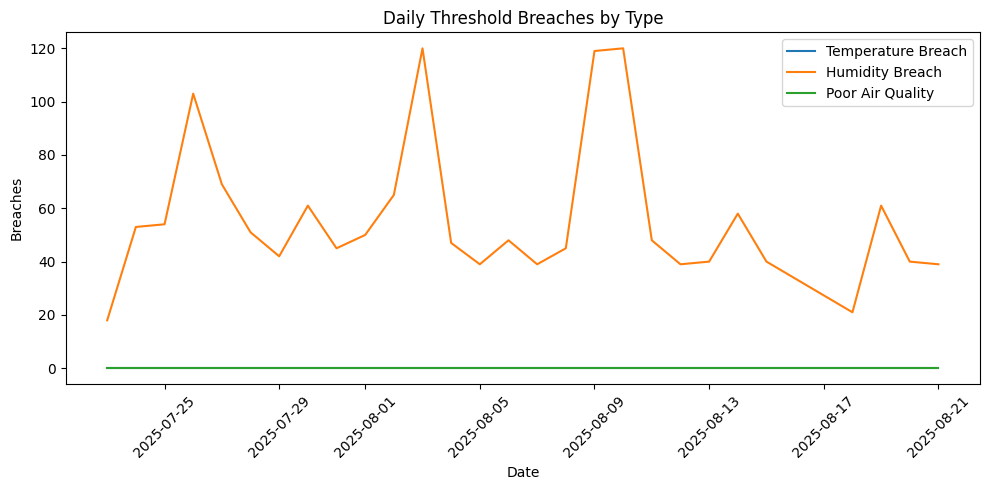

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(daily_breaches["day"], daily_breaches["temp_breach_count"], label="Temperature Breach")
plt.plot(daily_breaches["day"], daily_breaches["hum_breach_count"], label="Humidity Breach")
plt.plot(daily_breaches["day"], daily_breaches["poor_airq_count"], label="Poor Air Quality")
plt.legend()
plt.title("Daily Threshold Breaches by Type")
plt.ylabel("Breaches")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Humidity contributes the majority of daily breaches compared to temperature and air quality. This suggests ventilation/humidity control is the primary challenge in our factory environment.

#### Load a month ago data

In [17]:
conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                     user=DB_USER, password=DB_PASS, database=DB_NAME)

# pull recent data from a month ago
sql = """
SELECT created_at, temperature, humidity, air_quality
FROM sensor_feeds
WHERE created_at >= NOW() - INTERVAL 30 DAY
ORDER BY created_at;
"""
recent_data = pd.read_sql(sql, conn, parse_dates=["created_at"])
conn.close()

print(recent_data.head(), recent_data.tail(), recent_data.shape)

/tmp/ipython-input-2995825832.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  recent_data = pd.read_sql(sql, conn, parse_dates=["created_at"])


           created_at  temperature  humidity  air_quality
0 2025-07-28 12:53:13     28.81056  62.56504         23.0
1 2025-07-28 13:05:16     28.74113  62.63523         23.0
2 2025-07-28 13:17:19     28.87198  62.54368         23.0
3 2025-07-28 13:29:22     28.92805  62.37736         23.0
4 2025-07-28 13:41:25     29.01083  62.00809         23.0               created_at  temperature  humidity  air_quality
2527 2025-08-21 16:37:02     26.17227  62.80308         22.0
2528 2025-08-21 16:49:04     26.32715  62.33615         22.0
2529 2025-08-21 17:01:07     26.28710  62.60624         22.0
2530 2025-08-21 17:13:10     26.24437  62.58793         22.0
2531 2025-08-21 17:25:13     26.13222  62.78477         22.0 (2532, 4)


#### Make an hourly aggregation (time‑of‑day)

In [18]:
# Ensure timestamp is datetime (SG local stored)
recent_data["hour"] = recent_data["created_at"].dt.hour
recent_data["day"]  = recent_data["created_at"].dt.date

hourly = (recent_data.groupby("hour", as_index=True)
            .agg(avg_temp=("temperature","mean"),
                 avg_hum =("humidity","mean"),
                 avg_airq=("air_quality","mean"),
                 n=("temperature","count"))
            .round(2))

hourly

,avg_temp,avg_hum,avg_airq,n
hour,,,,
0,27.77,73.56,24.19,104
1,27.82,75.10,24.28,104
2,27.83,76.09,24.26,105
3,27.83,76.45,24.20,105
4,27.83,76.83,23.98,105
5,27.83,77.58,23.79,104
6,27.72,78.14,24.59,105
7,27.37,74.19,24.69,105
8,27.00,69.44,24.07,104


#### Plot multi‑line hourly trend (Temp / RH / AQ)

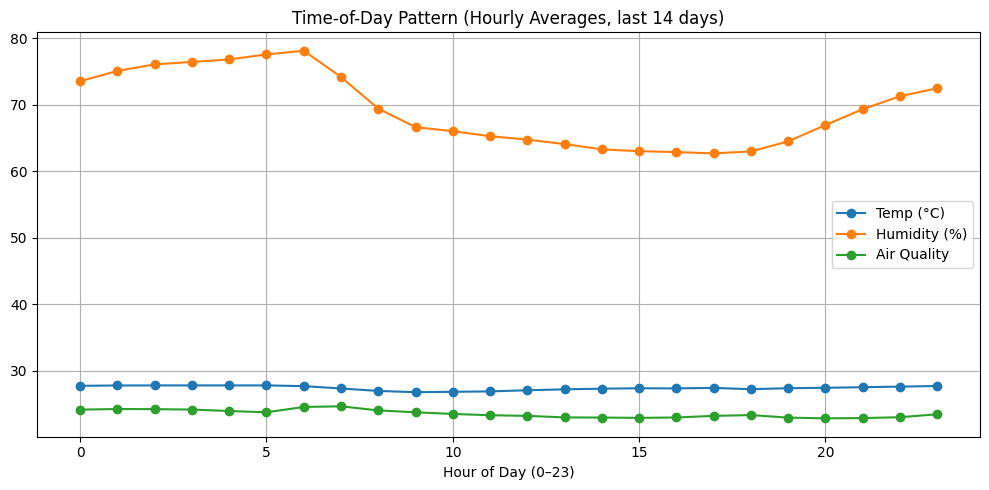

In [19]:
plt.figure(figsize=(10,5))
plt.plot(hourly.index, hourly["avg_temp"], marker="o", label="Temp (°C)")
plt.plot(hourly.index, hourly["avg_hum"],  marker="o", label="Humidity (%)")
plt.plot(hourly.index, hourly["avg_airq"], marker="o", label="Air Quality")
plt.title("Time-of-Day Pattern (Hourly Averages, last 14 days)")
plt.xlabel("Hour of Day (0–23)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


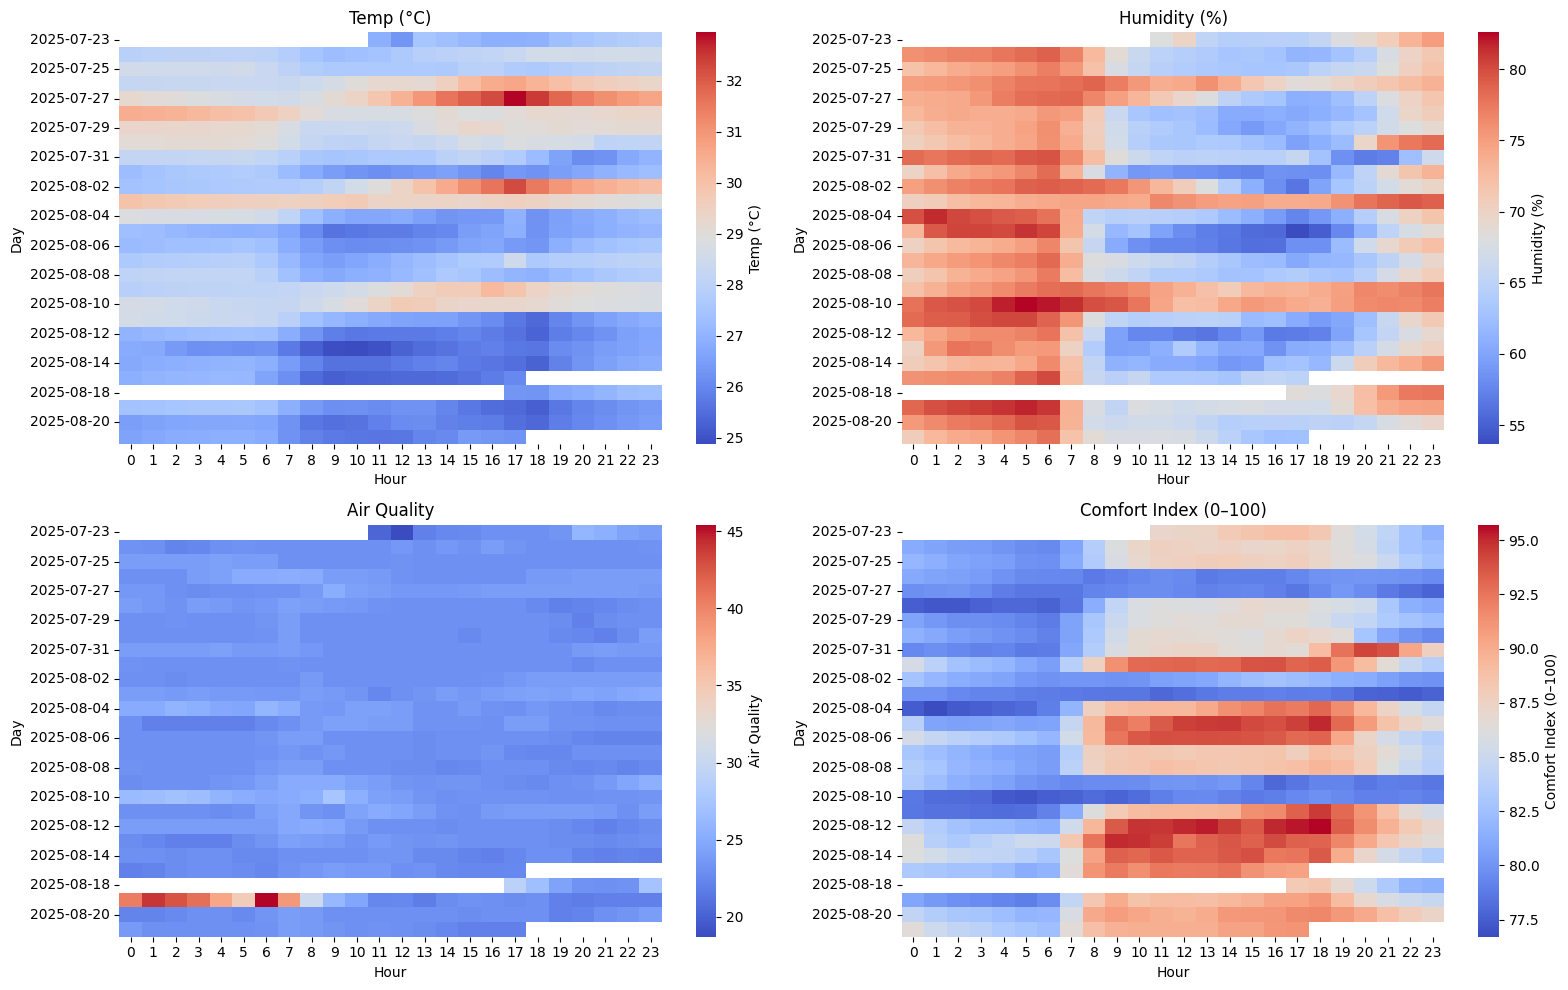

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# derive comfort index
def comfort_index(temp, hum, airq):
    # weighted & normalized to 0–100
    return max(0, min(100,
        100 - (abs(temp-25)*2 + abs(hum-50)*0.5 + max(0,airq-50)*0.8)
    ))

df["comfort_index"] = df.apply(lambda r: comfort_index(r["temperature"],
                                                       r["humidity"],
                                                       r["air_quality"]), axis=1)

# reshape for heatmap
df["day"]  = df["created_at"].dt.date
df["hour"] = df["created_at"].dt.hour

agg = df.groupby(["day","hour"]).mean(numeric_only=True).reset_index()

# make 4 pivots
pivots = {
    "Temp (°C)": agg.pivot(index="day", columns="hour", values="temperature"),
    "Humidity (%)": agg.pivot(index="day", columns="hour", values="humidity"),
    "Air Quality": agg.pivot(index="day", columns="hour", values="air_quality"),
    "Comfort Index (0–100)": agg.pivot(index="day", columns="hour", values="comfort_index"),
}

# plot 4 heatmaps
fig, axes = plt.subplots(2,2,figsize=(16,10))
for ax,(title,data) in zip(axes.ravel(), pivots.items()):
    sns.heatmap(data, cmap="coolwarm", ax=ax, cbar_kws={'label': title})
    ax.set_title(title); ax.set_xlabel("Hour"); ax.set_ylabel("Day")

plt.tight_layout()
plt.show()

**The Insight**
The heatmaps reveal that worker comfort drops significantly during afternoons (high temperature), humid nights, and occasional air quality spikes. These combined environmental stressors directly lower the Comfort Index, showing that comfort is not caused by a single factor but by the interaction of multiple parameters.

**The Solution**

Implement an Integrated Smart Ventilation and Monitoring System that automatically responds to environmental changes:

Smart fans / HVAC trigger when temperature > 32 °C.

Dehumidifiers / air circulation activate when humidity > 75%.

Air filters or exhaust systems engage when air quality worsens.

The SCIMAS dashboard sends real-time alerts to supervisors so they can act immediately.(alreay did in our dashboard)

### **Forecast next‑hour Comfort Index**

#### Load the data from MySQL View

In [22]:
conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                     user=DB_USER, password=DB_PASS, database=DB_NAME)

# Use the view so we don’t recompute CI in Python
sql = """
SELECT created_at, temperature, humidity, air_quality, comfort_index
FROM v_timeseries_comfort
ORDER BY created_at
"""
comfort_df = pd.read_sql(sql, conn, parse_dates=["created_at"])
conn.close()

comfort_df.tail()

/tmp/ipython-input-2768200970.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  comfort_df = pd.read_sql(sql, conn, parse_dates=["created_at"])


,created_at,temperature,humidity,air_quality,comfort_index
3133,2025-08-21 16:37:02,26.17227,62.80308,22.0,64.09
3134,2025-08-21 16:49:04,26.32715,62.33615,22.0,64.17
3135,2025-08-21 17:01:07,26.28710,62.60624,22.0,64.10
3136,2025-08-21 17:13:10,26.24437,62.58793,22.0,64.13
3137,2025-08-21 17:25:13,26.13222,62.78477,22.0,64.11


#### Resample hourly + feature engineering

In [23]:
import numpy as np

hourly = (comfort_df.set_index("created_at")   # use timestamp column as index
            .resample("1H")                   # group data into 1-hour intervals
            .mean()                           # take average of all readings in each hour
            .ffill()                          # fill forward any missing values
            .reset_index())                   # bring 'created_at' back as a normal column


# 2. Create calendar/time features
hourly["hour"] = hourly["created_at"].dt.hour       # hour of day (0–23)
hourly["dow"]  = hourly["created_at"].dt.dayofweek  # day of week (0=Monday, 6=Sunday)


for c in ["temperature", "humidity", "air_quality", "comfort_index"]:
    # Lag features (values from previous hours)
    hourly[f"{c}_lag1"]  = hourly[c].shift(1)   # value from 1 hour ago
    hourly[f"{c}_lag2"]  = hourly[c].shift(2)   # value from 2 hours ago
    hourly[f"{c}_lag3"]  = hourly[c].shift(3)   # value from 3 hours ago

    # Rolling (moving average) features
    hourly[f"{c}_roll3"]  = hourly[c].rolling(3,  min_periods=1).mean()   # average of last 3 hours
    hourly[f"{c}_roll6"]  = hourly[c].rolling(6,  min_periods=1).mean()   # average of last 6 hours
    hourly[f"{c}_roll12"] = hourly[c].rolling(12, min_periods=1).mean()   # average of last 12 hours

# 4. Define prediction target
hourly["ci_t_plus_1"] = hourly["comfort_index"].shift(-1)
# target variable = comfort index 1 hour ahead (next hour)

# 5. Remove incomplete rows
data = hourly.dropna().copy()  # drop rows with NaN (caused by shifting/rolling at edges)

# 6. Separate features and target
FEATURES = [c for c in data.columns
            if c not in ["created_at", "ci_t_plus_1", "comfort_index"]]  # input columns only
TARGET = "ci_t_plus_1"  # label column

X = data[FEATURES].values       # feature matrix (inputs for ML model)
y = data[TARGET].values         # target vector (outputs we want to predict)
ts_index = data["created_at"].values  # timestamps (useful for labeling results/plots)



/tmp/ipython-input-1402413355.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")                   # group data into 1-hour intervals


#### TimeSeriesSplit CV and models

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import math

# Evaluation metric function
def eval_metrics(y_true, y_pred):
    """
    Compute evaluation metrics:
    - MAE  (Mean Absolute Error): average absolute difference between prediction and truth
    - RMSE (Root Mean Squared Error): penalises larger errors more heavily
    - R²   (Coefficient of Determination): goodness of fit (1.0 = perfect)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Use TimeSeriesSplit (respects temporal order, avoids data leakage)
tscv = TimeSeriesSplit(n_splits=5)

# To collect results for each fold
rf_scores = []
xgb_scores = []

# modest hyperparams (safe defaults)
rf_params = dict(n_estimators=500, random_state=42, n_jobs=-1)
xgb_params = dict(
    n_estimators=50, learning_rate=0.05, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="reg:squarederror", tree_method="hist", random_state=42
)


# Cross-validation loop
fold = 1
for train_idx, test_idx in tscv.split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    # RandomForest
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_scores.append(eval_metrics(y_test, rf_pred))

    # XGBoost on the last 10% of train as eval
    split = int(len(X_train)*0.9)
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(
        X_train[:split], y_train[:split],
        eval_set=[(X_train[split:], y_train[split:])],
        verbose=False,
    )
    xgb_pred = xgb.predict(X_test)
    xgb_scores.append(eval_metrics(y_test, xgb_pred))

    print(f"Fold {fold}:")
    rf_mae, rf_rmse, rf_r2 = rf_scores[-1]
    print(f"  RF  -> MAE={rf_mae:.3f}, RMSE={rf_rmse:.3f}, R²={rf_r2:.3f}")
    x_mae, x_rmse, x_r2 = xgb_scores[-1]
    print(f"  XGB -> MAE={x_mae:.3f}, RMSE={x_rmse:.3f}, R²={x_r2:.3f}")
    fold += 1

def summarize(name, scores):
    arr = np.array(scores)
    m = arr.mean(axis=0); s = arr.std(axis=0)
    print(f"\n{name} (CV mean ± std)")
    print(f"  MAE : {m[0]:.3f} ± {s[0]:.3f}")
    print(f"  RMSE: {m[1]:.3f} ± {s[1]:.3f}")
    print(f"  R²  : {m[2]:.3f} ± {s[2]:.3f}")

summarize("RandomForest", rf_scores)
summarize("XGBoost", xgb_scores)

Fold 1:
  RF  -> MAE=0.699, RMSE=1.063, R²=0.768
  XGB -> MAE=1.087, RMSE=1.470, R²=0.556
Fold 2:
  RF  -> MAE=0.601, RMSE=0.795, R²=0.914
  XGB -> MAE=1.017, RMSE=1.330, R²=0.759
Fold 3:
  RF  -> MAE=0.475, RMSE=0.647, R²=0.922
  XGB -> MAE=0.574, RMSE=0.810, R²=0.878
Fold 4:
  RF  -> MAE=0.525, RMSE=0.643, R²=0.897
  XGB -> MAE=0.471, RMSE=0.596, R²=0.912
Fold 5:
  RF  -> MAE=0.731, RMSE=1.443, R²=0.738
  XGB -> MAE=0.947, RMSE=1.672, R²=0.648

RandomForest (CV mean ± std)
  MAE : 0.606 ± 0.098
  RMSE: 0.918 ± 0.303
  R²  : 0.848 ± 0.079

XGBoost (CV mean ± std)
  MAE : 0.819 ± 0.248
  RMSE: 1.176 ± 0.407
  R²  : 0.750 ± 0.135


#### n_estimator tuning
To reduce the training time and resources

   n_estimators  mean_R2  std_R2
0             1   0.7444  0.0992
1            25   0.8485  0.0696
2            50   0.8488  0.0756
3           100   0.8479  0.0759
4           200   0.8473  0.0788
5           300   0.8479  0.0792
6           500   0.8477  0.0786
7           800   0.8470  0.0792


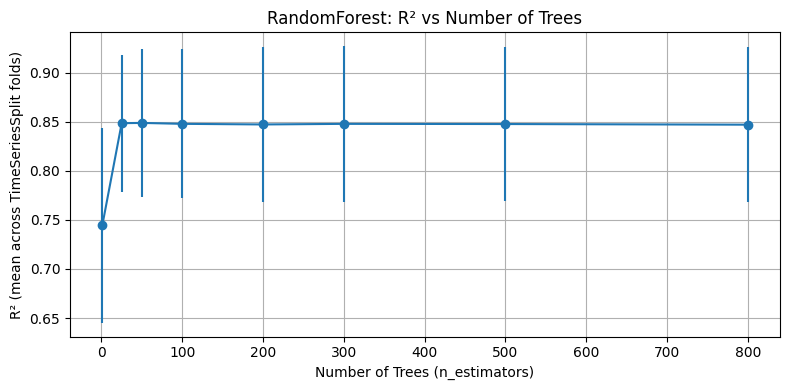

Best n_estimators = 50 with mean R² = 0.849 ± 0.076


In [25]:
# --- R² vs. Number of Trees (RandomForest) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

# and keep time-aware CV (same as before)
tscv = TimeSeriesSplit(n_splits=5)

# Grid of tree counts to test
n_estimators_list = [1, 25, 50, 100, 200, 300, 500, 800]

mean_r2 = []
std_r2  = []
all_scores = {}

for n in n_estimators_list:
    fold_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        rf = RandomForestRegressor(
            n_estimators=n,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        fold_scores.append(r2_score(y_test, y_pred))

    all_scores[n] = fold_scores
    mean_r2.append(np.mean(fold_scores))
    std_r2.append(np.std(fold_scores))

# Tabulate results
df_r2 = pd.DataFrame({
    "n_estimators": n_estimators_list,
    "mean_R2": np.round(mean_r2, 4),
    "std_R2": np.round(std_r2, 4)
})
print(df_r2)

# Plot mean ± std as error bars
plt.figure(figsize=(8,4))
plt.errorbar(n_estimators_list, mean_r2, yerr=std_r2, fmt='-o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("R² (mean across TimeSeriesSplit folds)")
plt.title("RandomForest: R² vs Number of Trees")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: highlight best n
best_idx = int(np.argmax(mean_r2))
best_n = n_estimators_list[best_idx]
best_mean = mean_r2[best_idx]
best_std = std_r2[best_idx]
print(f"Best n_estimators = {best_n} with mean R² = {best_mean:.3f} ± {best_std:.3f}")


#### Fit the best model on all data + 24‑hour forecast

In [26]:
# Pick the best model by mean R² across CV folds
rf_mean_r2  = np.mean([r[2] for r in rf_scores])   # avg R² for RandomForest
xgb_mean_r2 = np.mean([r[2] for r in xgb_scores])  # avg R² for XGBoost
winner = "xgb" if xgb_mean_r2 >= rf_mean_r2 else "rf"
print("Winner:", winner.upper())

# Choose the best model with saved hyperparams
if winner == "xgb":
    best = XGBRegressor(**xgb_params)
else:
    best = RandomForestRegressor(**rf_params)

# Fit best model on all available data
best.fit(X, y)

# Forecast next 24 hours (step by step)
last_row = data.iloc[-1:].copy()   # start from the last known row
future_rows = []
from datetime import timedelta
steps = 24   # forecast horizon = 24 hours

for i in range(steps):
    # ---- Predict next-hour comfort index ----
    feats = last_row[FEATURES].values
    ci_next = float(best.predict(feats))

    # ---- Advance timestamp by 1 hour ----
    ts_next = last_row["created_at"].iloc[0] + pd.Timedelta(hours=1)

    # ---- Keep sensor values constant (naive carry-forward) ----
    t_next = float(last_row["temperature"].iloc[0])
    h_next = float(last_row["humidity"].iloc[0])
    a_next = float(last_row["air_quality"].iloc[0])

    # ---- Create new row with base values ----
    new = {
        "created_at": ts_next,
        "temperature": t_next,
        "humidity": h_next,
        "air_quality": a_next,
        "comfort_index": ci_next,      # predicted CI
        "hour": ts_next.hour,
        "dow": ts_next.dayofweek
    }

    # ---- Update lags and rolling averages ----
    def lag(name):
        return [float(last_row[name].iloc[0]),              # latest value
                float(last_row.get(f"{name}_lag1", last_row[name]).iloc[0]),
                float(last_row.get(f"{name}_lag2", last_row[name]).iloc[0])]

    for var in ["temperature","humidity","air_quality","comfort_index"]:
        v0, v1, v2 = lag(var)
        # Shift lag values
        new[f"{var}_lag1"] = v0
        new[f"{var}_lag2"] = v1
        new[f"{var}_lag3"] = v2

        # Approximate update of rolling means with new value
        prev3  = float(last_row.get(f"{var}_roll3", pd.Series([v0])).iloc[0])
        prev6  = float(last_row.get(f"{var}_roll6", pd.Series([v0])).iloc[0])
        prev12 = float(last_row.get(f"{var}_roll12",pd.Series([v0])).iloc[0])
        new_val = ci_next if var=="comfort_index" else new[var]
        new[f"{var}_roll3"]  = (prev3*3  + new_val)/4
        new[f"{var}_roll6"]  = (prev6*6  + new_val)/7
        new[f"{var}_roll12"] = (prev12*12+ new_val)/13

    # ---- Save forecasted result ----
    future_rows.append({
        "created_at": ts_next,
        "ci_forecast": ci_next
    })

    # ---- Move forward (use new row as last_row for next step) ----
    last_row = pd.DataFrame([new])


# Build forecast dataframe
fcast = pd.DataFrame(future_rows)
fcast.head()


Winner: RF


/tmp/ipython-input-1967161684.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_next = float(best.predict(feats))
/tmp/ipython-input-1967161684.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_next = float(best.predict(feats))
/tmp/ipython-input-1967161684.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_next = float(best.predict(feats))
/tmp/ipython-input-1967161684.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is 

,created_at,ci_forecast
0,2025-08-21 17:00:00,64.003933
1,2025-08-21 18:00:00,63.928797
2,2025-08-21 19:00:00,63.781350
3,2025-08-21 20:00:00,63.578225
4,2025-08-21 21:00:00,63.397311


#### Plot: last 48h actual + next 24h forecast

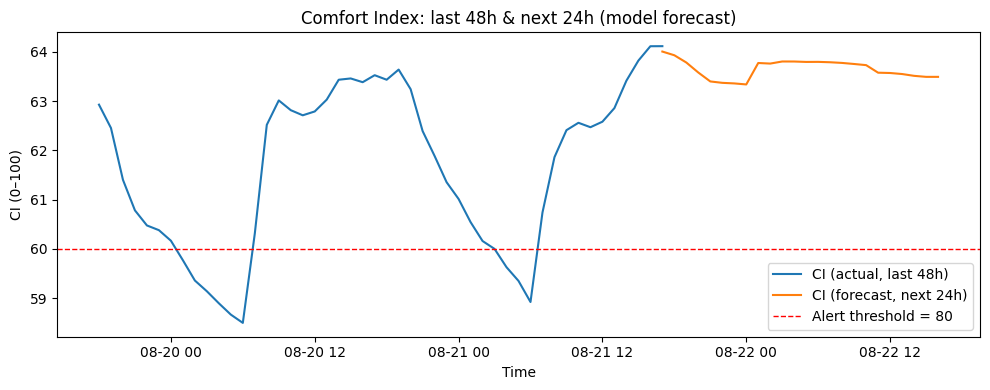

In [27]:
import matplotlib.pyplot as plt

hist = hourly.iloc[-48:][["created_at","comfort_index"]].rename(columns={"comfort_index":"ci_actual"})
plt.figure(figsize=(10,4))
plt.plot(hist["created_at"], hist["ci_actual"], label="CI (actual, last 48h)")
plt.plot(fcast["created_at"], fcast["ci_forecast"], label="CI (forecast, next 24h)")
plt.axhline(60, color="r", ls="--", lw=1, label="Alert threshold = 80")
plt.legend(); plt.title("Comfort Index: last 48h & next 24h (model forecast)")
plt.xlabel("Time"); plt.ylabel("CI (0–100)"); plt.tight_layout(); plt.show()


In [28]:
conn = mysql.connect(host=NGROK_HOST, port=NGROK_PORT,
                     user=DB_USER, password=DB_PASS, database=DB_NAME)
cur = conn.cursor()

rows = list(fcast[["created_at","ci_forecast"]].itertuples(index=False, name=None))
cur.executemany("""
INSERT INTO predictions_ci(ts, ci_forecast)
VALUES (%s,%s)
ON DUPLICATE KEY UPDATE ci_forecast=VALUES(ci_forecast);
""", rows)

conn.commit(); cur.close(); conn.close()
print(f"Wrote {len(rows)} forecast rows to predictions_ci")

Wrote 24 forecast rows to predictions_ci
